In [1]:
# Import General Libraries 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Deep Learning Libraries
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import text

# Privacy Package
from privacy.analysis.rdp_accountant import compute_rdp
from privacy.analysis.rdp_accountant import get_privacy_spent
from privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer

Using TensorFlow backend.
W0726 12:12:50.900544 140026058209088 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0726 12:12:50.905072 140026058209088 deprecation_wrapper.py:119] From /home/thomas/Downloads/privacy/privacy/optimizers/dp_optimizer.py:230: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.

W0726 12:12:50.905928 140026058209088 deprecation_wrapper.py:119] From /home/thomas/Downloads/privacy/privacy/optimizers/dp_optimizer.py:231: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0726 12:12:50.906849 140026058209088 deprecation_wrapper.py

In [2]:
# Parameters
dpsgd = True
learning_rate = 0.25
noise_multiplier = 1.8
l2_norm_clip = .1
batch_size = 256
epochs = 3
microbatches = 1
model_dir = None

In [3]:
def data_processing():
    data = pd.read_csv('datasets/hmda_GAVANCSC_clean.csv')
    
    dataevensamp = pd.concat([(data[data["action_taken_name"] == 1]).sample(n=len(data[data["action_taken_name"]==0])),
                          data[data["action_taken_name"]==0]])
    data = dataevensamp.sample(frac=1)

    target = data['action_taken_name']
    target = to_categorical(target) 
    predictors = data.drop(['action_taken_name'], axis=1)
    predictors = predictors.drop(predictors.columns[0], axis=1)
    
    return predictors, target

In [4]:
def compute_epsilon(steps):
  """Computes epsilon value for given hyperparameters."""
  if noise_multiplier == 0.0:
    return float('inf')
  orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
  sampling_probability = batch_size / predictors.shape[0]
  rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=noise_multiplier,
                    steps=steps,
                    orders=orders)
  # Delta is set to 1e-5 because MNIST has 60000 training points.
  return get_privacy_spent(orders, rdp, target_delta=1e-5)[0]

In [5]:
predictors, target = data_processing()

n_cols = predictors.shape[1]

optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=microbatches,
    learning_rate=learning_rate,
    unroll_microbatches=True)

x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.20, random_state = 0)

In [6]:
nonprivatemodel = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape = (n_cols,)),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(6, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax'),
])

nonprivatemodel.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

nonprivatemodel.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1)

print('\n# Evaluate on test data')
results = nonprivatemodel.evaluate(x_test, y_test, batch_size=batch_size)
print('test loss, test acc:', results)

W0726 12:12:53.899814 140026058209088 deprecation.py:506] From /home/thomas/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/3
285728/285728 [==============================] - 3s 12us/sample - loss: 0.5943 - acc: 0.6844
Epoch 2/3
285728/285728 [==============================] - 3s 10us/sample - loss: 0.5650 - acc: 0.7086
Epoch 3/3
285728/285728 [==============================] - 3s 10us/sample - loss: 0.5609 - acc: 0.7116

# Evaluate on test data
71432/71432 [==============================] - 0s 7us/sample - loss: 0.5573 - acc: 0.7132
test loss, test acc: [0.5573108607396419, 0.7131538]


In [7]:
privatemodel = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape = (n_cols,)),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(6, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax'),
])

privatemodel.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

privatemodel.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose = 1)
scores = privatemodel.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (privatemodel.metrics_names[1], scores[1]*100))
eps = compute_epsilon(epochs * predictors.shape[0] // batch_size)
print('For delta=1e-5, the current epsilon is: %.2f' % eps)

Train on 228582 samples, validate on 57146 samples


W0726 12:13:04.443840 140026058209088 deprecation.py:323] From /home/thomas/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/clip_ops.py:286: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0726 12:13:04.463621 140026058209088 deprecation_wrapper.py:119] From /home/thomas/Downloads/privacy/privacy/dp_query/gaussian_query.py:101: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Epoch 1/3
228582/228582 [==============================] - 3s 14us/sample - loss: 0.7896 - acc: 0.5059 - val_loss: 0.6913 - val_acc: 0.5010
Epoch 2/3
228582/228582 [==============================] - 3s 13us/sample - loss: 0.7540 - acc: 0.4970 - val_loss: 0.7421 - val_acc: 0.4956
Epoch 3/3
228582/228582 [==============================] - 3s 13us/sample - loss: 1.1620 - acc: 0.5050 - val_loss: 1.0639 - val_acc: 0.5029
acc: 49.88%
For delta=1e-5, the current epsilon is: 0.27


In [8]:
y_true = y_test

y_true_one_col = []
y_true_one_col = np.argmax(y_true, axis=1)
from sklearn.metrics import confusion_matrix
y_pred = nonprivatemodel.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
print('-' * 30)
print('Nonprivate confusion matrix:')
print(confusion_matrix(y_true_one_col, y_pred))
print('-' * 30)
print()
from sklearn.metrics import confusion_matrix
y_pred = privatemodel.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
print('-' * 30)
print('Private confusion matrix:')
print(confusion_matrix(y_true_one_col, y_pred))
print('-' * 30)

------------------------------
Nonprivate confusion matrix:
[[24361 11549]
 [ 8941 26581]]
------------------------------

------------------------------
Private confusion matrix:
[[  748 35162]
 [  638 34884]]
------------------------------


In [9]:
import lime
import lime.lime_tabular
feature_names=list(x_train.columns)
categorical_indices=[]
for x in range(0, len(feature_names)):
    if("name" in feature_names[x] or "abbr" in feature_names[x]):
        categorical_indices.append(x)
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=feature_names, categorical_features=categorical_indices, verbose=False, discretize_continuous=True, discretizer='decile')

In [10]:
import random
i = random.randint(0,x_test.shape[0])
print('Index: ', i)

Index:  33245


In [11]:
exp = explainer.explain_instance(x_test.iloc[i], nonprivatemodel.predict_proba, num_features=x_test.shape[1])
exp.show_in_notebook(show_table=True)

In [12]:
exp.as_list()

[('loan_purpose_name=1', 0.281393570163161),
 ('property_type_name=1', 0.272103301437214),
 ('lien_status_name=1', -0.22520959027156057),
 ('applicant_race_name_1=1', 0.1441719446703149),
 ('number_of_1_to_4_family_units > 0.66', -0.0642048003193128),
 ('agency_abbr=1', -0.057540621842887385),
 ('applicant_ethnicity_name=1', 0.055796746427251714),
 ('number_of_owner_occupied_units > 0.60', 0.048488874687106095),
 ('0.41 < loan_amount_000s <= 0.43', 0.023961647533829785),
 ('loan_type_name=0', -0.02104237378948838),
 ('applicant_sex_name=1', 0.013437949860796708),
 ('population > 0.59', 0.01055121207598725),
 ('co_applicant_sex_name=1', -0.0069431528137301884),
 ('0.70 < tract_to_msamd_income <= 0.72', 0.0068175426928872235),
 ('owner_occupancy_name=1', 0.006564778766217712),
 ('0.54 < minority_population <= 0.60', 0.005092009387604959),
 ('0.31 < applicant_income_000s <= 0.33', 0.0006138631223794952),
 ('0.32 < hud_median_family_income <= 0.36', -0.000397782042757403)]

In [59]:
exp = explainer.explain_instance(x_test.iloc[i], privatemodel.predict_proba, num_features=x_test.shape[1])
exp.show_in_notebook(show_table=True)

In [15]:
p1 = x_test.iloc[i]
p2 = x_test.iloc[i]
p2['applicant_race_name_1'] = 1 - p2['applicant_race_name_1']
data = pd.DataFrame([p1, p2])
print(nonprivatemodel.predict_proba(data))
print(privatemodel.predict_proba(data))

[[0.4524647  0.5475353 ]
 [0.6103458  0.38965425]]
[[0.46460626 0.53539383]
 [0.49173775 0.5082622 ]]


/home/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
topN = 5
ranking ={}
for x in feature_names:
    ranking[x] = []
    for y in range(0,topN):
        ranking[x].append(0)

In [67]:
for index, row in x_test.iterrows():
    break
    exp = explainer.explain_instance(row, privatemodel.predict_proba, num_features=x_test.shape[1])
    explist = exp.as_list()
    for x in range(0,topN):
        item = explist[x][0]
        key = item.split('=')[0]
        if ' < ' in key:
            key = key.split(' < ')[1]
        if ' ' in key:
            key = key.split(' ')[0]
        ranking[key][x] += 1
print(ranking)

{'tract_to_msamd_income': [0, 0, 0, 0, 0], 'population': [0, 0, 0, 0, 0], 'minority_population': [0, 0, 0, 0, 0], 'number_of_owner_occupied_units': [0, 0, 0, 0, 0], 'number_of_1_to_4_family_units': [0, 0, 0, 0, 0], 'loan_amount_000s': [0, 0, 0, 0, 0], 'hud_median_family_income': [0, 0, 0, 0, 0], 'applicant_income_000s': [0, 0, 0, 0, 0], 'property_type_name': [0, 0, 0, 0, 0], 'owner_occupancy_name': [0, 0, 0, 0, 0], 'loan_type_name': [0, 0, 0, 0, 0], 'loan_purpose_name': [0, 0, 0, 0, 0], 'lien_status_name': [0, 0, 0, 0, 0], 'co_applicant_sex_name': [0, 0, 0, 0, 0], 'applicant_sex_name': [0, 0, 0, 0, 0], 'applicant_race_name_1': [0, 0, 0, 0, 0], 'applicant_ethnicity_name': [0, 0, 0, 0, 0], 'agency_abbr': [0, 0, 0, 0, 0]}


In [8]:
import lime
import lime.lime_tabular
feature_names=list(x_train.columns)
categorical_indices=[]
for x in range(0, len(feature_names)):
    if("name" in feature_names[x] or "abbr" in feature_names[x]):
        categorical_indices.append(x)
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=feature_names, categorical_features=categorical_indices, verbose=False, discretize_continuous=True, discretizer='decile')

In [9]:
def rankingFn(row, predict_proba, rankingsDict):
    exp = explainer.explain_instance(row, predict_proba, num_features=x_test.shape[1])
    explist = exp.as_list()
    for x in range(0,topN):
        item = explist[x][0]
        key = item.split('=')[0]
        if ' < ' in key:
            key = key.split(' < ')[1]
        if ' ' in key:
            key = key.split(' ')[0]
        rankingsDict[key][x] += 1

In [10]:
privatemodels = []
nummodels = 5
for x in range(0,nummodels):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape = (n_cols,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
    ])

    model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

    privatemodels.append(model)

In [11]:
for m in privatemodels:
    m.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose = 0)
    scores = m.evaluate(x_test, y_test, verbose=0)
    print("%s: %.2f%%" % (m.metrics_names[1], scores[1]*100))

acc: 59.82%
acc: 57.63%
acc: 55.90%
acc: 62.39%
acc: 59.59%


In [12]:
nonprivatemodels = []
for x in range(0,nummodels):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape = (n_cols,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax'),
    ])

    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

    nonprivatemodels.append(model)

In [13]:
for m in nonprivatemodels:
    m.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose = 0)
    scores = m.evaluate(x_test, y_test, verbose=0)
    print("%s: %.2f%%" % (m.metrics_names[1], scores[1]*100))

acc: 71.05%
acc: 71.23%
acc: 70.91%
acc: 71.03%
acc: 71.13%


In [14]:
all_models = [nonprivatemodels, privatemodels]

In [15]:
test_data = x_test.sample(n=10)

In [16]:
all_rankings = []
for models in all_models:
    type_rankings = []
    for m in models:
        topN = 5
        ranking ={}
        for x in feature_names:
            ranking[x] = []
            for y in range(0,topN):
                ranking[x].append(0)
        test_data.apply(rankingFn, axis=1, args=[m.predict_proba, ranking])
        type_rankings.append(ranking)
    all_rankings.append(type_rankings)

In [17]:
all_rankings

[[{'tract_to_msamd_income': [0, 0, 0, 0, 0],
   'population': [0, 0, 0, 0, 0],
   'minority_population': [0, 0, 0, 0, 0],
   'number_of_owner_occupied_units': [0, 0, 0, 0, 0],
   'number_of_1_to_4_family_units': [0, 0, 0, 0, 0],
   'loan_amount_000s': [0, 0, 0, 3, 1],
   'hud_median_family_income': [0, 0, 0, 0, 0],
   'applicant_income_000s': [0, 0, 0, 0, 3],
   'property_type_name': [0, 10, 0, 0, 0],
   'owner_occupancy_name': [0, 0, 0, 0, 0],
   'loan_type_name': [0, 0, 0, 0, 0],
   'loan_purpose_name': [10, 0, 0, 0, 0],
   'lien_status_name': [0, 0, 10, 0, 0],
   'co_applicant_sex_name': [0, 0, 0, 0, 0],
   'applicant_sex_name': [0, 0, 0, 0, 0],
   'applicant_race_name_1': [0, 0, 0, 7, 3],
   'applicant_ethnicity_name': [0, 0, 0, 0, 0],
   'agency_abbr': [0, 0, 0, 0, 3]},
  {'tract_to_msamd_income': [0, 0, 0, 0, 0],
   'population': [0, 0, 0, 0, 0],
   'minority_population': [0, 0, 0, 0, 0],
   'number_of_owner_occupied_units': [0, 0, 0, 0, 0],
   'number_of_1_to_4_family_units': [0

In [89]:
ranking = privateRankings[0]
remitems = []
for key in ranking:
    if np.sum(ranking[key]) == 0:
         remitems.append(key)
for item in remitems:
    del ranking[item]
ranking

{'number_of_owner_occupied_units': [0, 0, 0, 0, 1],
 'number_of_1_to_4_family_units': [0, 0, 0, 0, 6],
 'property_type_name': [0, 0, 0, 0, 33],
 'owner_occupancy_name': [0, 0, 0, 0, 54],
 'loan_type_name': [0, 0, 0, 100, 0],
 'loan_purpose_name': [0, 0, 0, 0, 4],
 'applicant_sex_name': [0, 0, 100, 0, 0],
 'applicant_race_name_1': [0, 100, 0, 0, 0],
 'applicant_ethnicity_name': [0, 0, 0, 0, 2],
 'agency_abbr': [100, 0, 0, 0, 0]}

In [90]:
len(ranking)

10

In [91]:
ind = np.arange(len(ranking))
width = .35
d = sorted(ranking.items(), key=lambda x:(np.sum(x[1]),x[1][0],x[1][1],x[1][2],x[1][3],x[1][4]))

In [92]:
pltdata = []
for x in range(0,topN):
    pltdata.append([])
    for y in range(0,len(ranking)):
        pltdata[x].append(0)

In [93]:
d

[('number_of_owner_occupied_units', [0, 0, 0, 0, 1]),
 ('applicant_ethnicity_name', [0, 0, 0, 0, 2]),
 ('loan_purpose_name', [0, 0, 0, 0, 4]),
 ('number_of_1_to_4_family_units', [0, 0, 0, 0, 6]),
 ('property_type_name', [0, 0, 0, 0, 33]),
 ('owner_occupancy_name', [0, 0, 0, 0, 54]),
 ('loan_type_name', [0, 0, 0, 100, 0]),
 ('applicant_sex_name', [0, 0, 100, 0, 0]),
 ('applicant_race_name_1', [0, 100, 0, 0, 0]),
 ('agency_abbr', [100, 0, 0, 0, 0])]

In [94]:
for x in range(0,len(d)):
    for y in range(0,len(d[x][1])):
        pltdata[y][x] += d[x][1][y]
pltdata

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 100],
 [0, 0, 0, 0, 0, 0, 0, 0, 100, 0],
 [0, 0, 0, 0, 0, 0, 0, 100, 0, 0],
 [0, 0, 0, 0, 0, 0, 100, 0, 0, 0],
 [1, 2, 4, 6, 33, 54, 0, 0, 0, 0]]

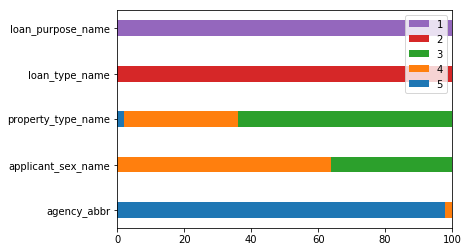

In [132]:
plots = []
for index in range(0,len(pltdata)):
    index = len(pltdata) - index - 1
    row = tuple(pltdata[index])
    offset = np.zeros(len(pltdata[0]))
    for x in range(index+1,len(pltdata)):
        for y in range(0, len(pltdata[x])):
            offset[y] += pltdata[x][y]
    offset = tuple(offset)
    plots.insert(0,plt.barh(ind, row, width, left=offset))
colors, names = [], []
for x in range(0, len(plots)):
    colors.append(plots[x][0])
    names.append(x + 1)
plt.legend(colors, names)
labels = []
for item in d:
    labels.append(item[0])
plt.yticks(ind, labels)

plt.show()

In [54]:
colored_names = {
    'tract_to_msamd_income' : 'black',
    'population' : 'black',
    'minority_population' : 'black',
    'number_of_owner_occupied_units' : 'black',
    'number_of_1_to_4_family_units' : 'black' ,
    'loan_amount_000s' : 'green',
    'hud_median_family_income' : 'black',
    'applicant_income_000s' : 'green',
    'property_type_name' : 'green',
    'owner_occupancy_name' : 'green',
    'loan_type_name' : 'green',
    'loan_purpose_name' : 'green',
    'lien_status_name' : 'green',
    'co_applicant_sex_name' : 'green',
    'applicant_sex_name' : 'red',
    'applicant_race_name_1' : 'red',
    'applicant_ethnicity_name' : 'red',
    'agency_abbr' : 'black'
}
renamed_features = {
    'tract_to_msamd_income' : 'Tract Income Ratio',
    'population' : 'Population',
    'minority_population' : 'Tract % Minority',
    'number_of_owner_occupied_units' : 'Tract # Owners',
    'number_of_1_to_4_family_units' : 'Tract # Families' ,
    'loan_amount_000s' : 'Loan Amount',
    'hud_median_family_income' : 'Tract Income',
    'applicant_income_000s' : 'App. Income',
    'property_type_name' : 'Property Type',
    'owner_occupancy_name' : 'Owner Occupancy',
    'loan_type_name' : 'Loan Type',
    'loan_purpose_name' : 'Loan Purpose',
    'lien_status_name' : 'Lien Status',
    'co_applicant_sex_name' : 'Has Co-app',
    'applicant_sex_name' : 'App. Sex',
    'applicant_race_name_1' : 'App. Race',
    'applicant_ethnicity_name' : 'App. Ethnicity',
    'agency_abbr' : 'Agency'
}
colored_bars = [
    (208/255,209/255,230/255),
    (166/255,189/255,219/255),
    (116/255,169/255,207/255),
    (43/255,140/255,190/255),
    (4/255,90/255,141/255)
]
colored_bars.reverse()

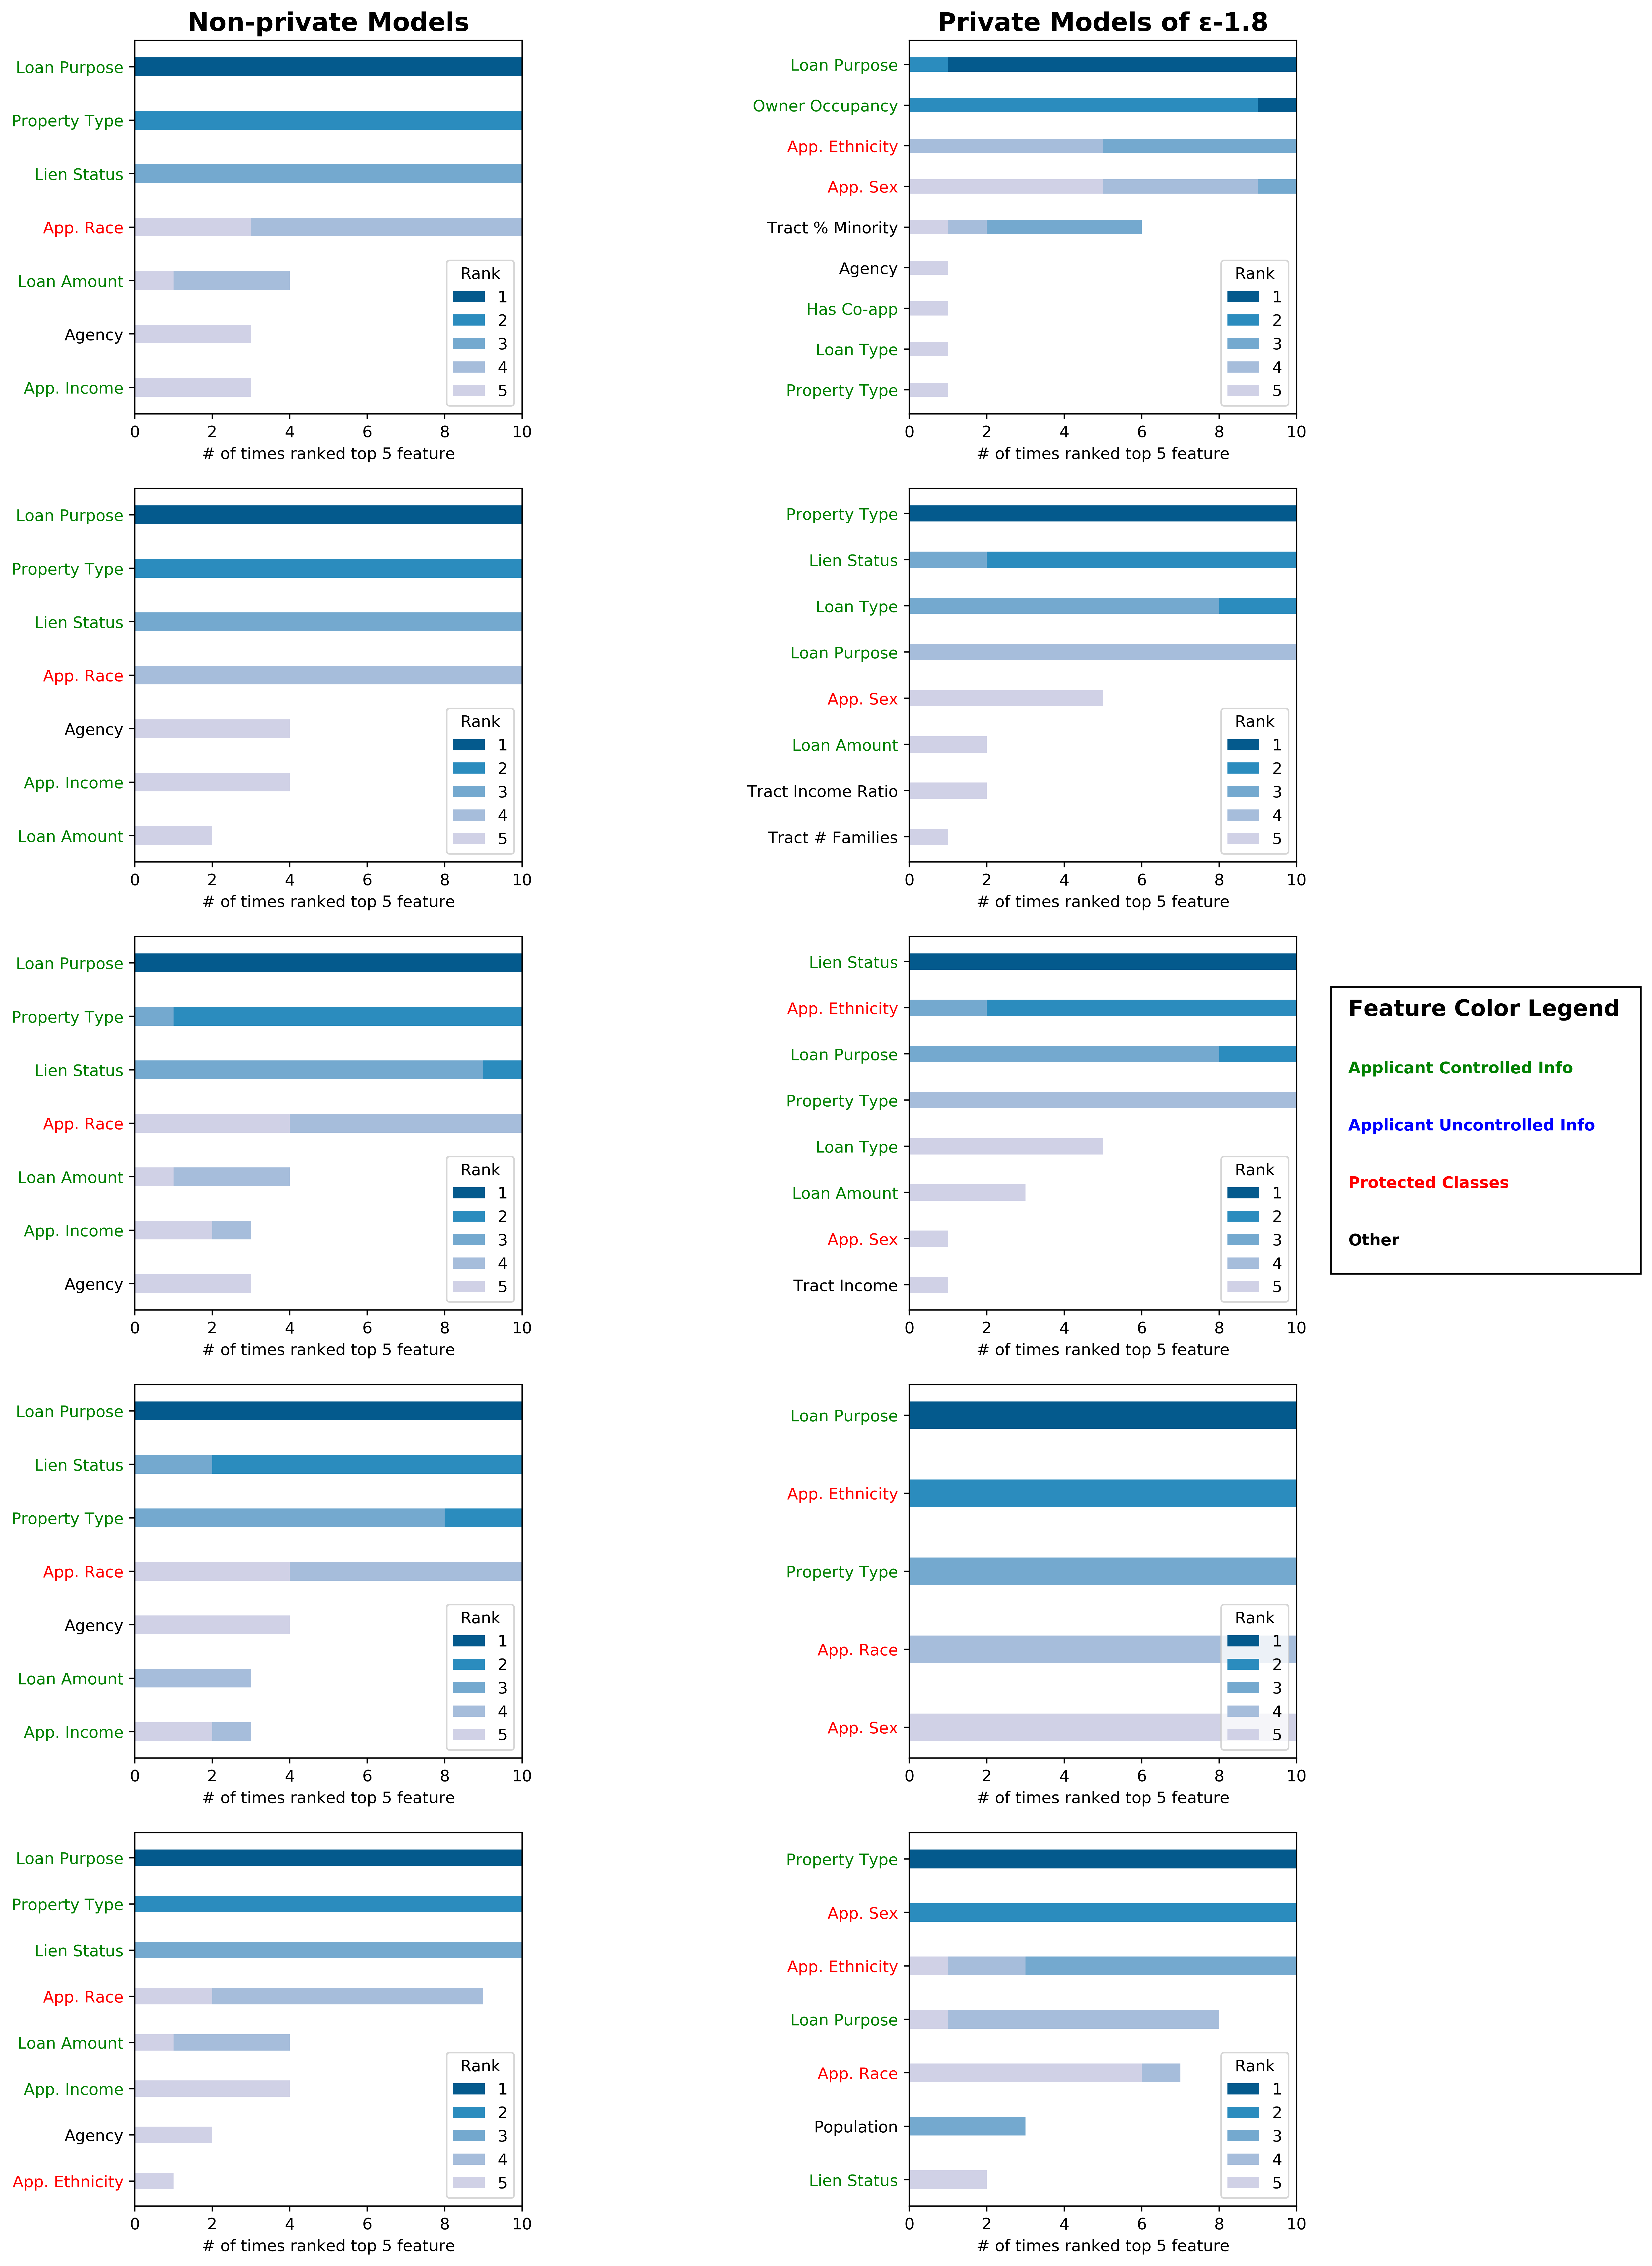

In [55]:
fig = plt.figure(figsize=(15, 25),dpi=400)
gs = plt.GridSpec(len(all_models[0]),len(all_models))
plt.subplots_adjust(right=.8)
plt.figtext(.83, .54, 'Feature Color Legend', color='black', fontweight='bold', size=14)
plt.figtext(.83, .52, 'Applicant Controlled Info', color='green', fontweight='bold')
plt.figtext(.83, .50, 'Applicant Uncontrolled Info', color='blue', fontweight='bold')
plt.figtext(.83, .48, 'Protected Classes', color='red', fontweight='bold')
plt.figtext(.83, .46, 'Other', color='black', fontweight='bold')

fig.patches.extend([plt.Rectangle((0.82,0.45),0.18,0.1,
                                  fill=False, color='black', alpha=1, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])


plots = []
for row in range(len(all_models)):
    plots.append([])
    for col in range(len(all_models[0])):
        plots[row].append(fig.add_subplot(gs[col,row]))
plt.subplots_adjust(wspace=1)
for row in range(len(plots)):
    for col in range(len(plots[row])):
        #Rankings is slimmed down to only entries with numbers
        ranking = all_rankings[row][col]
        remitems = []
        for key in ranking:
            if np.sum(ranking[key]) == 0:
                remitems.append(key)
        for item in remitems:
            del ranking[item]
        #Sorts rankings
        ind = np.arange(len(ranking))
        width = .35
        d = sorted(ranking.items(), key=lambda x:(np.sum(x[1]),x[1][0],x[1][1],x[1][2],x[1][3],x[1][4]))
    
        #Establishes pltdata
        pltdata = []
        for x in range(0,topN):
            pltdata.append([])
            for y in range(0,len(ranking)):
                pltdata[x].append(0)
        for x in range(0,len(d)):
            for y in range(0,len(d[x][1])):
                pltdata[y][x] += d[x][1][y]
    
    
        for index in range(0,len(pltdata)):
            index = len(pltdata) - index - 1
            info = tuple(pltdata[index])
            offset = np.zeros(len(pltdata[0]))
            for x in range(index+1,len(pltdata)):
                for y in range(0, len(pltdata[x])):
                    offset[y] += pltdata[x][y]
            offset = tuple(offset)
            plots[row][col].barh(ind, info, width, left=offset, label=(index+1), color=colored_bars[index])
    
        labels = []
        for item in d:
            labels.append(item[0])
        if col == 0:
            if row == 0:
                plots[row][col].set_title('Non-private Models', fontweight='bold', size=16)
            else:
                plots[row][col].set_title(('Private Models of ε-' + (str)(round(compute_epsilon(epochs * predictors.shape[0] // batch_size), 2))), fontweight='bold', size=16)
        #plots[row][col].set_title('Private Model ' + str(i+1))
        plots[row][col].set_yticks(ind)
        pltlabels = plots[row][col].set_yticklabels(labels)
        [i.set_color(colored_names[i.get_text()]) for i in pltlabels]
        for x in range(len(labels)):
            labels[x] = renamed_features[labels[x]]
        pltlabels = plots[row][col].set_yticklabels(labels)
        handles, labels = plots[row][col].get_legend_handles_labels()
        plots[row][col].legend(handles[::-1], labels[::-1], title='Rank', loc='lower right')
        plots[row][col].set_xlabel('# of times ranked top 5 feature')
    
plt.savefig('all_model_valued_features_ep_' + str(round(compute_epsilon(epochs * predictors.shape[0] // batch_size), 2)) + '.png', bbox_inches='tight')
plt.show()

In [47]:
allcomprankings = []
for x in range(2):
    rankdict = {}
    for feature in feature_names:
        rankdict[feature] = np.zeros(topN)
    for rankinglist in all_rankings[x]:
        for feature in feature_names:
            if feature in rankinglist:
                for x in range(topN):
                    rankdict[feature][x] += rankinglist[feature][x]
    allcomprankings.append([ [k,v] for k, v in rankdict.items() ])

In [126]:
ind = np.arange(len(feature_names))
width = .45
pltdata = np.zeros((2,5,18))
for x in range(len(allcomprankings)):
    for y in range(len(allcomprankings[x])):
        for z in range(len(allcomprankings[x][y][1])):
            pltdata[x][z][y] += allcomprankings[x][y][1][z]

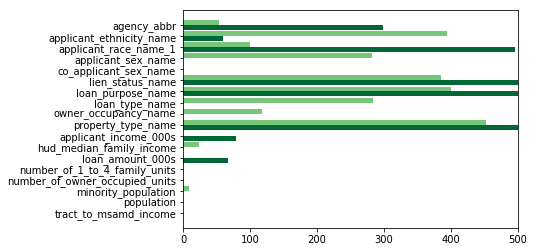

In [129]:
for h in range(len(pltdata)):
    for i in range(len(pltdata[h])):
        index = len(pltdata[h]) - i - 1
        info = tuple(pltdata[h][index])
        offset = np.zeros(len(pltdata[h][0]))
        for x in range(index+1,len(pltdata[h])):
            for y in range(0, len(pltdata[h][x])):
                offset[y] += pltdata[h][x][y]
        offset = tuple(offset)
        plt.barh(ind + width*h, info, width, left=offset, label=(index+1), color=colored_bars[h*2])
plt.yticks(ind+width/2, feature_names)
plt.show()